In [15]:
using Interact
using Gadfly
using Distributions

In [2]:
set_default_plot_size(25cm,10cm)

<br>

# 1. Numerical derivatives

## Exercise 1.

Let f be a continuous and twice differentiable function of x in the interval [0.05, 2], such that:

$$ f(x) = 2 - 0.5x^{-0.5}-0.5x^{-0.2} $$

Compute the analytical derivative and numerical derivatives with both forward and two-sided approximation. Evaluate the three functions in the [0.05, 2] interval and plot the absolute values of the difference between the analytical derivative and each numerical approximation. What do you conclude?

_________

In [3]:
f(x) = 2-0.5x^(-0.5)-0.5x^(-.02);

Analytical derivative:

$$ f'(x) = 0.25x^{-1.5}+0.1x^{-1.2} $$

In [4]:
df(x) = 0.25x^(-1.5)+0.1x^(-1.2);

Numerical derivative - forward approximation:

$$ f'(x_0) \approx \frac{f(x_0+h)-f(x_0-h)}{h}, \quad h=x-x_0 $$

In [5]:
df_forward(x) = (f(x+h)-f(x))/h; h = 10.0^-10;

Numerical derivative - two-sided approximation:

$$ f'(x_0) \approx \frac{f(x_0+h)-f(x_0-h)}{2h}, \quad h=x-x_0 $$

In [6]:
df_2sided(x) = (f(x+h)-f(x-h))/(2h); h = 10.0^-10;

Let us now plot the results for the interval [0.5, 2]:

In [7]:
function ex1_Differenciation()
    
    x = 0.5:0.01:10

    results = plot(
        layer(x=x, y=df.(x), Geom.line, Theme(default_color=colorant"black")),
        layer(x=x, y=df_forward.(x), Geom.line, Theme(default_color=colorant"red")), # forward in red
        layer(x=x, y=df_2sided.(x), Geom.line, Theme(default_color=colorant"blue")), # two-sided in blue
        Guide.Title("Derivatives"),
        Guide.xlabel("x"),
        Guide.ylabel("f'(x)")
    )

    difference = plot(
        layer(x=x, y=abs.(df.(x)-df_forward.(x)), Geom.line, Theme(default_color=colorant"red")), # forward in red
        layer(x=x, y=abs.(df.(x)-df_2sided.(x)), Geom.line, Theme(default_color=colorant"blue")), # two-sided in blue
        Guide.Title("Absolute Error of the Approximations"),
        Guide.xlabel("x"),
        Guide.ylabel("Differences")
    )
    return hstack(results, difference)
end;

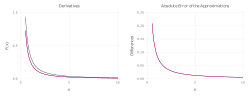

In [8]:
ex1_Differenciation()

In [9]:
println("Sum of the absolute error of the forward approximation:","\n", sum(abs.(df.(0.5:0.01:10)-df_forward.(0.5:0.01:10))),"\n")
println("Sum of the absolute error of the two-sided approximation:","\n", sum(abs.(df.(0.5:0.01:10)-df_2sided.(0.5:0.01:10))))

Sum of the absolute error of the forward approximation:
23.046544815621964

Sum of the absolute error of the two-sided approximation:
23.046518170269373


<br>

# 2. Numerical Integrals

## Exercise 2.

Let $f(x) = x^2$. Compute $\int^4_1 \ x^2 dx$ by making use of the left an right Riemann sums and the average of both. Compare the numerical approximations with the analytical solution for $n = 50,\ 500,\ 5000$.

_________

Analytical solution:

$$ \int^4_1 x^2 dx = \left[ \frac{x^3}{3} \right]_1^4 = \frac{64}{3} -\frac{1}{3} = 21 $$

Numerical approximation:

In [10]:
function ex2_RiemannSums()
    
    a = 1; b = 4; f(x) = x.^2
    results = ["n" "l_node" "r_node" "mean"; zeros(3, 4)]
    
    for (i, n) in enumerate([50, 500, 5000])
        dx = (b-a)/n
        l_int = dx*f.(a:dx:4-dx)  
        r_int = dx*f.(a+dx:dx:4)
        results[i+1,:] = [n sum(l_int) sum(r_int) sum(.5*(l_int+r_int))]
    end
    
    return results
end;

In [11]:
ex2_RiemannSums()

4×4 Array{Any,2}:
     "n"    "l_node"    "r_node"    "mean"
   50.0   20.5518     21.4518     21.0018 
  500.0   20.955      21.045      21.0    
 5000.0   20.9955     21.0045     21.0    

<br>

## Exercise 3.

The manager of a supermarket has to decide each day how much bread to buy. For every bread that it is sold, there is a profit of 60 cents. However, for every one not sold, there is a loss of 40 cents. The demand is uniformily distributed in the interval [80, 140]. How much bread should the manager order, in order to maximize the profit? What if the demand follows the Gamma distribution, with parameters k = 2 and θ = 55?

_____________

Formalizing the problem. Let $P$ denote the profit. Then:

$$ P = \begin{cases} 0.6Q, & \mbox{if } D\geq Q \\ 0.6D-0.4(Q-D), & \mbox{if } D < Q \end{cases}$$

Uniform distribution - analytical solution:

$$ \underset{\textbf{Q}}{\text{max}} \ E[P] =  \underset{\textbf{Q}}{\text{max}} \left[ \int^Q_{80} [0.6x-0.4(Q-x)]\frac{1}{60}dx  + \int^{140}_{Q} 0.6Q\frac{1}{60}dx \right]$$

$$ Q^\ast = 116 \quad E[P] = 101.47$$

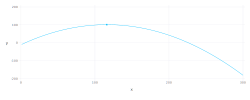

In [12]:
function ex3_Uniform(Q)
    return (-1/120)Q^2+(29/15)Q-32/3
end

plot(layer(x=1:300, y=ex3_Uniform.(1:300), Geom.line),
    layer(x=[116], y=[101.47], Geom.point)
)

Gamma distribution - analytical formulation:

$$ \underset{\textbf{Q}}{\text{max}} \ E[P] =  \underset{\textbf{Q}}{\text{max}} \left[ \int^Q_{80} [0.6x-0.4(Q-x)]\frac{1}{\Gamma(k)\theta^k}x^{k-1} dx  + \int^{140}_{Q} 0.6Q\frac{1}{\Gamma(k)\theta^k}x^{k-1} dx \right]$$

Gamma distribution - Numerical approximation:

In [13]:
function ex3_MonteCarlo()
    
    k = 2; θ = 55
    
    results = ["n" "Optimal Q" "E[P]"]
    
    for n in [5 500 5000]
        Q = quantile.(Gamma(k,θ), rand(n))
        
        gQ = pdf.(Gamma(k,θ),Q)
        P = zeros(n)
        D = rand(Gamma(k,θ),n)
        mP = zeros(n)
        
        for i in 1:n
            for j in 1:n
                if D[j] >= Q[i]
                    P[j] = 0.6*Q[i]
                else
                    P[j] = 0.6*D[j]-0.5(Q[i]-D[j])
                end
            end
            mP[i] = mean(P)
        end
        
        Pfunc = [Q mP]
        Q_EP = []
        max_pair = Pfunc[findfirst(Pfunc[:,2], maximum(Pfunc[:,2])),:]'
        
        results = [results; n max_pair[1] max_pair[2]] 
    
    end
    
    return results
end;

In [14]:
ex3_MonteCarlo()

4×3 Array{Any,2}:
     "n"     "Optimal Q"    "E[P]"
    5.0    69.3069        17.9061 
  500.0    98.7182        32.4981 
 5000.0   101.292         33.3719 

<br>